# Latent Net implementation

>> Notes to the new implementation - debugging


>> - the implementation of the Fourier features is wrong. get back to that later
>> - make sure that the train function loops over the parameters that are part  of the train set (i.e. the alphas that define the training sims)
>> - the append operation
>> - plot the latent state
>> - remove the train_snaphots and test_snapshots variables
>> - for each parameter, I train always on the same positions. to be changed?

In [1]:
# Install PyTorch
try:
  import torch
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch

#torch.set_default_dtype(torch.float32)

In [2]:
# Install PyG
try:
  import torch_geometric
except ImportError:
  !pip3 install torch_geometric
  import torch_geometric

In [3]:
import numpy as np

In [4]:
# Import some utils from gca-rom
import sys
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/Fra-Sala/gnn_time.git
    sys.path.append('gnn_time')
else:
    sys.path.append('./..')
    
#from gca_rom import pde, scaling
from latent_net import dynamics_network, initialization, loader, preprocessing_scale, train

/home/francesco/anaconda3/envs/fenicsproject/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [5]:
variable = 'U'
problem_name = 'lid_cavity'
print("\nProblem: ", problem_name)
print("Variable: ", variable)



Problem:  lid_cavity
Variable:  U


In [6]:
# Parameters to be set

#preset = [3, 2, 2, 2, 1, 3, 3, 1]

train_rate = 50 ###### Shrink train dataset
dim_latent = 10
epochs = 1000
dt = 1e-1 # For forward euler
scaling_type = 2 # scale only against the features
scaler_number = 3 # type of scaling function. 3 -> standard

argv = [problem_name, variable, scaling_type, scaler_number, train_rate, 1e-3, 1e-3, dim_latent, dt, epochs]
HyperParams = dynamics_network.HyperParams(argv)

# Initialization

In [7]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)

Device used:  cpu


# Load dataset

In [8]:
if 'google.colab' in str(get_ipython()):
    dataset_dir = '/content/gnn_time/dataset/'+problem_name+'_unstructured.mat'
else:
    dataset_dir = '../dataset/'+problem_name+'_unstructured.mat'

# Import the data from the mat file 
dataset = loader.LoadDataset(dataset_dir, variable)

# Delete the initial condition of each case
dataset.U = np.delete(dataset.U, np.s_[::10], 1)

# Take first 3 snaps for two simulations
# cols_to_delete = list(range(3, 9)) + list(range(12, dataset.U.shape[1]))
# dataset.U = np.delete(dataset.U, cols_to_delete, 1)


### DEBUG: take only the first two snapshots

dataset.U = np.delete(dataset.U,np.s_[1:],1 )

In [9]:
dataset.U

tensor([[0.0380],
        [0.0000],
        [0.0000],
        ...,
        [0.0009],
        [0.0009],
        [0.0041]])

In [10]:
# New approach for the parameters. Just store u(t) for all snapshots and the time t. if necessary, interpolate u(t) linearly

# if 'google.colab' in str(get_ipython()):
#     u_t_latent = np.load('/content/gnn_time/lid_driven_cavity_fenics/u_t_latent.npy')
# else:
#     u_t_latent = np.load('../lid_driven_cavity_fenics/u_t_latent.npy')

# Import the single Fourier mode
if 'google.colab' in str(get_ipython()):
    alpha1_vec = np.load('/content/gnn_time/lid_driven_cavity_fenics/alpha1.npy')
else:
    alpha1_vec = np.load('../lid_driven_cavity_fenics/alpha1.npy')

############ TAKE ONLY THE FIRST two PARAMETER (FOURIER COEFF) #############
params = alpha1_vec[0:1]
time = np.linspace(0.0, 0.2, 2)

# Get rid of the initial condition evaluation (0.0)
# u_t_latent = np.delete(u_t_latent, np.s_[::10], 0)   
# u_t_tensor = torch.from_numpy(u_t_latent)
time_tensor = torch.from_numpy(time)
print("Number of simulations (series of snaps):", len(params))
print("Number of instants of time:", len(time)-1)

#alpha1_vec = alpha1_vec.reshape(-1,1)


Number of simulations (series of snaps): 1
Number of instants of time: 1


In [11]:
train_loader, test_loader, scaler_all,\
scaler_test, VAR_all, VAR_test, train_snapshots,\
test_snapshots, position_dataset, params_train, params_test = preprocessing_scale.process_and_scale_dataset(dataset, HyperParams, params)

Number of nodes processed:  15681
Number of simulations processed:  1


In [12]:
data_test_iterator = iter(test_loader)
data_test = next(data_test_iterator).to(device)
data_test[:, :, 0]

tensor([[ 1.0000, -1.0000, -1.0000,  ..., -0.9511, -0.9505, -0.7828]])

# Define the architecture

In [13]:
# The dynamics net takes u(t) as input and s(t)
dyn_input_size = 1 + HyperParams.dim_latent
dyn_hidden_size = 9
dim = 2 # we are in 2D

#rec_input_size = dim*HyperParams.rff_encoded_mult*HyperParams.batch_pos_size + HyperParams.dim_latent
rec_input_size = dim*HyperParams.batch_pos_size + HyperParams.dim_latent
rec_hidden_size = dyn_hidden_size
rec_output_size = HyperParams.batch_pos_size


dyn_model = dynamics_network.DynNet(dyn_input_size, dyn_hidden_size, HyperParams.dim_latent)
rec_model = dynamics_network.RecNet(rec_input_size, rec_hidden_size, rec_output_size)
dyn_model = dyn_model.to(device)
rec_model = rec_model.to(device)

# Define optimizers for both models
#dyn_optimizer = torch.optim.Adam(list(dyn_model.parameters()) + list(rec_model.parameters()), lr=HyperParams.learning_rate,  weight_decay=HyperParams.weight_decay)
#optimizer = torch.optim.Adam(list(dyn_model.parameters()) + list(rec_model.parameters()), lr=HyperParams.learning_rate,  weight_decay=HyperParams.weight_decay)
torch.set_default_dtype(torch.float32)
optimizer = torch.optim.Adam([
    {'params': dyn_model.parameters()},
    {'params': rec_model.parameters()}
], lr=HyperParams.learning_rate,  weight_decay=HyperParams.weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)

# Train the network

In [14]:
train_history, test_history = train.train_dyn_rec_nets(dyn_model, rec_model, optimizer, scheduler,\
                          device, params_train, params_test, time_tensor, train_loader, test_loader, position_dataset,\
                              train_snapshots, test_snapshots, HyperParams)

100%|██████████| 1000/1000 [01:43<00:00,  9.62it/s, Loss(training)=3.11e-5, Loss(test)=3.11e-5] 


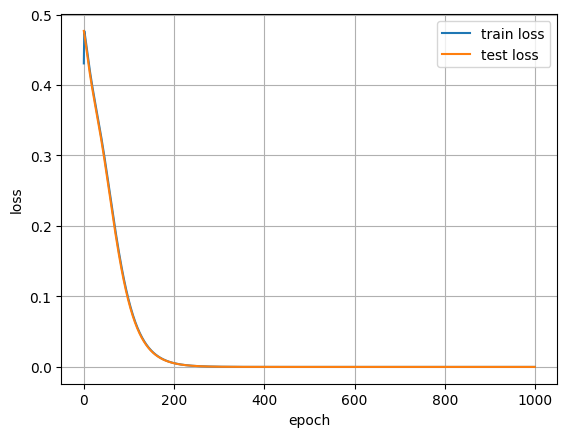

In [15]:
from matplotlib import pyplot as plt

plt.plot(train_history['loss'], label='train loss')
plt.plot(test_history['loss'], label='test loss')
plt.legend()

plt.grid()

plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
